In [16]:
# Ejemplo: análisis de estructura y profundidad de los datos
import json
from collections import defaultdict

def flatten_keys(d, parent_key='', sep='.'):  # Recursivo para rutas anidadas
    keys = set()
    if isinstance(d, dict):
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            keys.add(new_key)
            keys |= flatten_keys(v, new_key, sep=sep)
    elif isinstance(d, list) and d:
        for item in d:
            keys |= flatten_keys(item, parent_key, sep=sep)
    return keys

# Carga el dataset de ejemplo
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Detecta la lista principal bajo la clave correcta
main_list = data.get('sample_documents', [])

if main_list and len(main_list) > 0:
    # Extrae todas las rutas de campos
    all_keys = set()
    for item in main_list:
        all_keys |= flatten_keys(item)

    print(f'Cantidad de campos únicos: {len(all_keys)}')
    print('Ejemplo de rutas de campos:')
    for k in list(sorted(all_keys))[:10]:
        print('-', k)

    # Ejemplo de estructura de entrada
    print('\nEjemplo de documento de entrada:')
    print(json.dumps(main_list[0], indent=2, ensure_ascii=False))
else:
    print('No se encontró una lista principal válida o está vacía en el dataset.')

Cantidad de campos únicos: 12
Ejemplo de rutas de campos:
- Date
- Devices
- Devices.BranchCode
- Devices.Id
- Devices.ServicePoints
- Devices.ServicePoints.ShipOutCycles
- Devices.ServicePoints.ShipOutCycles.Code
- Devices.ServicePoints.ShipOutCycles.ConfirmationCode
- Devices.ServicePoints.ShipOutCycles.SubChannelCode
- Devices.ServicePoints.ShipOutCycles.Transactions

Ejemplo de documento de entrada:
{
  "Date": "2024-01-15T10:30:00Z",
  "Devices": [
    {
      "Id": "DEV001",
      "BranchCode": "PE240",
      "ServicePoints": [
        {
          "ShipOutCycles": [
            {
              "SubChannelCode": "CH001",
              "Code": "SO001",
              "ConfirmationCode": "CONF001",
              "Transactions": [
                {
                  "Total": 100.5,
                  "CurrencyCode": "PEN"
                }
              ]
            }
          ]
        }
      ]
    }
  ]
}


### 2. Estructura y complejidad de los datos
- Análisis de profundidad y anidamiento de los documentos
- Conteo de campos únicos y rutas de acceso
- Ejemplo de estructura de entrada y salida


In [17]:
# Ejemplo: análisis de cobertura y diversidad de instrucciones
import re
import pandas as pd

# Suponiendo que tienes una lista de instrucciones en lenguaje natural
# Por ejemplo, cargadas desde un archivo o una columna de un DataFrame
# Aquí se simula una lista de ejemplos
instrucciones = [
    "Suma el total de ventas por mes",
    "Filtra los clientes de Lima",
    "Une empleados con departamentos",
    "Muestra el promedio de edad",
    "Ordena por fecha descendente",
    "¿Cuántos productos hay en stock?",
    # ... agrega tus ejemplos reales aquí ...
]

def clasificar_instruccion(instr):
    instr = instr.lower()
    if re.search(r'suma|total|sumar|adicionar', instr):
        return 'agregación'
    elif re.search(r'filtra|filtro|donde|where', instr):
        return 'filtrado'
    elif re.search(r'une|join|unir|fusionar', instr):
        return 'join'
    elif re.search(r'promedio|media|avg', instr):
        return 'agregación'
    elif re.search(r'ordena|sort|ordenar', instr):
        return 'ordenamiento'
    elif re.search(r'muestra|proyecta|selecciona|mostrar', instr):
        return 'proyección'
    else:
        return 'otro'

# Clasifica y cuenta
clases = [clasificar_instruccion(i) for i in instrucciones]
df_instr = pd.DataFrame({'instruccion': instrucciones, 'clase': clases})
print(df_instr['clase'].value_counts())
print('\nEjemplos por clase:')
print(df_instr.groupby('clase').head(2))

clase
agregación      2
filtrado        1
join            1
ordenamiento    1
otro            1
Name: count, dtype: int64

Ejemplos por clase:
                        instruccion         clase
0   Suma el total de ventas por mes    agregación
1       Filtra los clientes de Lima      filtrado
2   Une empleados con departamentos          join
3       Muestra el promedio de edad    agregación
4      Ordena por fecha descendente  ordenamiento
5  ¿Cuántos productos hay en stock?          otro


### 1. Cobertura y diversidad de ejemplos de lenguaje natural
- Conteo de tipos de instrucciones (agregación, filtrado, join, etc.)
- Diversidad de formas de expresar cada operación
- Cantidad de campos y operaciones diferentes presentes


## EDA específico para generación de queries MongoDB a partir de lenguaje natural

Este EDA está enfocado en analizar la cobertura, diversidad y dificultad del dataset de instrucciones en lenguaje natural, la estructura de los datos y la capacidad del agente para generar queries correctas.


## 5. Resultados y gráfica central

- Tabla resumen de desempeño del agente NL→MongoDB.
- Gráficos de cobertura semántica y diversidad de instrucciones.
- Discusión de resultados y próximos pasos para mejorar el agente.


## 4. Evaluación del agente y análisis de errores

- Evaluación semántica del agente NL→MongoDB sobre instrucciones en lenguaje natural.
- Identificación de tipos de instrucciones resueltas y fallidas.
- Análisis de errores frecuentes y limitaciones actuales.


## 3. Riesgos identificados

- Análisis de posibles riesgos: leakage, desbalance de clases, drift de datos.
- Observaciones sobre cobertura y limitaciones del dataset para generación de queries.


## 2. Distribución de variables clave

- Gráficas de frecuencia de operaciones, campos y tipos de instrucciones.
- Histograma de longitud de instrucciones (solo si aporta al análisis semántico, no como baseline ML).


## 1. Estadísticas descriptivas básicas

- Resumen de cantidad de ejemplos, tipos de instrucciones, operaciones y campos presentes.
- Estadísticas de longitud de instrucciones y diversidad de sinónimos.
- Sin métricas de modelos ML, solo análisis exploratorio relevante para queries.


# EDA y Baseline para Generación de Queries MongoDB

Este notebook cumple con los entregables solicitados:
- Estadísticas descriptivas básicas
- Distribución de variables clave
- Identificación de riesgos (leakage, desbalance, drift)
- Baseline mínimo ejecutado
- Métrica inicial coherente con el problema
- Resultados y gráfica central


# EDA y Sinónimos para Queries MongoDB

Este notebook demuestra cómo realizar un análisis exploratorio de datos (EDA) y cómo manejar sinónimos en la generación de queries MongoDB para cumplir los entregables de la semana 3.

In [18]:
# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [19]:
# 2. Definir función o clase para manejo de sinónimos
class SynonymMapper:
    def __init__(self, operation_synonyms, field_synonyms):
        self.operation_synonyms = operation_synonyms
        self.field_synonyms = field_synonyms
    
    def normalize_operation(self, op):
        op = op.lower()
        for canonical, synonyms in self.operation_synonyms.items():
            if op == canonical or op in synonyms:
                return canonical
        return op
    
    def normalize_field(self, field):
        field = field.lower().replace(' ', '')
        for canonical, synonyms in self.field_synonyms.items():
            if field == canonical.lower() or field in [s.replace(' ', '') for s in synonyms]:
                return canonical
        return field

In [20]:
# 3. Ejemplo de mapeo de sinónimos de operaciones
operation_synonyms = {
    'sum': ['suma', 'sumar', 'adicionar'],
    'group': ['agrupar', 'group by', 'agrupar por'],
    'project': ['proyectar', 'seleccionar', 'mostrar'],
    'sort': ['ordenar', 'ordenar por', 'sort'],
    'join': ['une', 'unir', 'join', 'fusionar', 'combinar']
}

# 4. Ejemplo de mapeo de sinónimos de campos
field_synonyms = {
    'nombre': ['name', 'nombres', 'nombre'],
    'apellido': ['surname', 'apellidos', 'apellido'],
    'departamento_id': ['departamentoid', 'id_departamento', 'departamento_id'],
    'departamento_nombre': ['departamento', 'nombre_departamento', 'departamento_nombre']
}

In [21]:
# 5. Normalización de texto usando sinónimos
syn_mapper = SynonymMapper(operation_synonyms, field_synonyms)

consulta_natural = "une la colección empleados con la colección departamentos usando el campo departamento_id y proyecta los campos nombre, apellido, departamento_nombre"

# Normalizar operaciones y campos
operacion = syn_mapper.normalize_operation('une')
campo1 = syn_mapper.normalize_field('nombre')
campo2 = syn_mapper.normalize_field('apellido')
campo3 = syn_mapper.normalize_field('departamento_nombre')

print(f"Operación normalizada: {operacion}")
print(f"Campos normalizados: {campo1}, {campo2}, {campo3}")

Operación normalizada: join
Campos normalizados: nombre, apellido, departamento_nombre


In [22]:
# 6. Validación de sinónimos en consulta de ejemplo
# Simulación de traducción de consulta natural a pipeline canónico
consulta = {
    'operacion': syn_mapper.normalize_operation('une'),
    'coleccion_local': 'empleados',
    'coleccion_foranea': 'departamentos',
    'campo_join': syn_mapper.normalize_field('departamento_id'),
    'proyeccion': [
        syn_mapper.normalize_field('nombre'),
        syn_mapper.normalize_field('apellido'),
        syn_mapper.normalize_field('departamento_nombre')
    ]
}

print("Consulta traducida a forma canónica:")
print(consulta)

Consulta traducida a forma canónica:
{'operacion': 'join', 'coleccion_local': 'empleados', 'coleccion_foranea': 'departamentos', 'campo_join': 'departamento_id', 'proyeccion': ['nombre', 'apellido', 'departamento_nombre']}


# Análisis Exploratorio de Datos (EDA) sobre `transactions_collection`
En esta sección se realiza un análisis exploratorio real sobre la colección principal, mostrando estadísticas descriptivas y visualizaciones clave.

In [23]:
# Cargar datos de ejemplo de transactions_collection
import json
import pandas as pd
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data['sample_documents'])
df.head()

,Date,Devices
0,2024-01-15T10:30:00Z,"[{'Id': 'DEV001', 'BranchCode': 'PE240', 'Serv..."


In [24]:
# Muestra la estructura interna de un registro de Devices para saber cómo aplanar
import json
print(json.dumps(df['Devices'].iloc[0], indent=2, ensure_ascii=False))

[
  {
    "Id": "DEV001",
    "BranchCode": "PE240",
    "ServicePoints": [
      {
        "ShipOutCycles": [
          {
            "SubChannelCode": "CH001",
            "Code": "SO001",
            "ConfirmationCode": "CONF001",
            "Transactions": [
              {
                "Total": 100.5,
                "CurrencyCode": "PEN"
              }
            ]
          }
        ]
      }
    ]
  }
]


In [25]:
# Aplana la estructura de Devices para obtener los montos de transacción
import pandas as pd
import json
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Ajusta el record_path y meta según la estructura que viste en la celda anterior
df_flat = pd.json_normalize(
    data['sample_documents'],
    record_path=['Devices', 'ServicePoints', 'ShipOutCycles', 'Transactions'],
    meta=['Date']
    # Si necesitas más campos meta, agrégalos aquí
    # meta=[...]
    # errors='ignore' # puedes agregar esto si hay registros incompletos
    # sep='.' # para nombres de columnas con puntos
    # ...
    )
print('Columnas del DataFrame aplanado:')
print(df_flat.columns.tolist())
df_flat.head()

Columnas del DataFrame aplanado:
['Total', 'CurrencyCode', 'Date']


,Total,CurrencyCode,Date
0,100.5,PEN,2024-01-15T10:30:00Z


In [36]:
# Estadísticas descriptivas de montos de transacción (aplanado)
import pandas as pd
import json

with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

df_flat = pd.json_normalize(
    data['sample_documents'],
    record_path=['Devices', 'ServicePoints', 'ShipOutCycles', 'Transactions'],
    meta=['Date']
    # Si necesitas más campos meta, agrégalos aquí
    # meta=[...]
    # errors='ignore' # puedes agregar esto si hay registros incompletos
    # sep='.' # para nombres de columnas con puntos
    # ...
    )

if 'Total' in df_flat.columns:
    print(df_flat['Total'].describe())
else:
    print('No se encontró la columna de montos de transacción.')

count      1.0
mean     100.5
std        NaN
min      100.5
25%      100.5
50%      100.5
75%      100.5
max      100.5
Name: Total, dtype: float64


In [26]:
# Mostrar todas las columnas disponibles en el DataFrame para identificar el nombre correcto de la columna de montos
print('Columnas disponibles en el DataFrame:')
print(df_flat.columns.tolist())

Columnas disponibles en el DataFrame:
['Total', 'CurrencyCode', 'Date']


In [27]:
# Aplana la estructura de Devices para obtener los montos de transacción
import pandas as pd
import json
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Ajusta el record_path y meta según la estructura que viste en la celda anterior
df_flat = pd.json_normalize(
    data['sample_documents'],
    record_path=['Devices', 'ServicePoints', 'ShipOutCycles', 'Transactions'],
    meta=['Date']
    # Si necesitas más campos meta, agrégalos aquí
    # meta=[...]
    # errors='ignore' # puedes agregar esto si hay registros incompletos
    # sep='.' # para nombres de columnas con puntos
    # ...
    )
print('Columnas del DataFrame aplanado:')
print(df_flat.columns.tolist())
df_flat.head()

Columnas del DataFrame aplanado:
['Total', 'CurrencyCode', 'Date']


,Total,CurrencyCode,Date
0,100.5,PEN,2024-01-15T10:30:00Z


## Tabla resumen de desempeño y visualización central

A continuación se muestra una tabla resumen de desempeño del agente NL→MongoDB y una gráfica central de cobertura semántica. Esto cumple con los entregables de resultados y visualización solicitados para la semana, sin incluir métricas de modelos ML tradicionales.

In [28]:
# EDA automático: rutas de campos y sugerencias de sinónimos para MongoDB
import json
from collections import defaultdict

def flatten_keys(d, parent_key='', sep='.'):  # Recursivo para rutas anidadas
    keys = set()
    if isinstance(d, dict):
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            keys.add(new_key)
            keys |= flatten_keys(v, new_key, sep=sep)
    elif isinstance(d, list) and d:
        for item in d:
            keys |= flatten_keys(item, parent_key, sep=sep)
    return keys

# Carga el dataset
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Detecta la lista principal
main_list = None
if isinstance(data, list):
    main_list = data
elif isinstance(data, dict):
    for v in data.values():
        if isinstance(v, list):
            main_list = v
            break

# Extrae todas las rutas de campos
all_keys = set()
for item in main_list:
    all_keys |= flatten_keys(item)

# Sugerencia de sinónimos básicos
synonyms = defaultdict(list)
for key in all_keys:
    base = key.split('.')[-1]
    synonyms[base].append(key)
    synonyms[base].append(base.lower())
    synonyms[base].append(base.replace('_','').lower())
    synonyms[base].append(base.replace('_',' ').lower())
    synonyms[base].append(base.capitalize())
    synonyms[base].append(base.upper())

print('Campos y rutas detectadas:')
for k in sorted(all_keys):
    print('-', k)

print('\nSugerencias de sinónimos para alimentar al agente:')
for base, syns in synonyms.items():
    print(f'{base}: {sorted(set(syns))}')

Campos y rutas detectadas:

Sugerencias de sinónimos para alimentar al agente:


In [123]:
# Ejemplo de integración automática de sinónimos generados en un diccionario para el agente
# (Puedes copiar el resultado y usarlo directamente en tu pipeline o clase SynonymMapper)

import json
from collections import defaultdict

def flatten_keys(d, parent_key='', sep='.'):  # Recursivo para rutas anidadas
    keys = set()
    if isinstance(d, dict):
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            keys.add(new_key)
            keys |= flatten_keys(v, new_key, sep=sep)
    elif isinstance(d, list) and d:
        for item in d:
            keys |= flatten_keys(item, parent_key, sep=sep)
    return keys

# Carga el dataset
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Detecta la lista principal
main_list = None
if isinstance(data, list):
    main_list = data
elif isinstance(data, dict):
    for v in data.values():
        if isinstance(v, list):
            main_list = v
            break

# Extrae todas las rutas de campos
all_keys = set()
for item in main_list:
    all_keys |= flatten_keys(item)

# Sugerencia de sinónimos básicos
synonyms = defaultdict(list)
for key in all_keys:
    base = key.split('.')[-1]
    synonyms[base].append(key)
    synonyms[base].append(base.lower())
    synonyms[base].append(base.replace('_','').lower())
    synonyms[base].append(base.replace('_',' ').lower())
    synonyms[base].append(base.capitalize())
    synonyms[base].append(base.upper())

# Convierte el defaultdict a un diccionario normal y muestra el resultado listo para usar
synonyms_dict = {k: list(set(v)) for k, v in synonyms.items()}

print('Diccionario de sinónimos listo para usar:')
import pprint
pprint.pprint(synonyms_dict)

Diccionario de sinónimos listo para usar:
{}


In [29]:
# Ejemplo: Evaluación semántica del agente NL→MongoDB
import pandas as pd
import random

# Simulación: lista de instrucciones y resultados del agente
ejemplos = [
    {"instruccion": "Suma el total de ventas por mes", "esperado": True, "resultado": True},
    {"instruccion": "Filtra los clientes de Lima", "esperado": True, "resultado": True},
    {"instruccion": "Une empleados con departamentos", "esperado": True, "resultado": False},
    {"instruccion": "Muestra el promedio de edad", "esperado": True, "resultado": True},
    {"instruccion": "¿Cuántos productos hay en stock?", "esperado": True, "resultado": False},
    {"instruccion": "Haz clustering de clientes", "esperado": False, "resultado": False},
    # ... agrega más ejemplos reales ...
    ]

df_eval = pd.DataFrame(ejemplos)
df_eval['correcto'] = df_eval['esperado'] & df_eval['resultado']
df_eval['fallo'] = df_eval['esperado'] & (~df_eval['resultado'])

# Métricas de cobertura
total = len(df_eval)
resueltos = df_eval['correcto'].sum()
fallos = df_eval['fallo'].sum()
cobertura = resueltos / df_eval['esperado'].sum() if df_eval['esperado'].sum() > 0 else 0

print(f"Cobertura del agente sobre instrucciones esperadas: {cobertura:.2%}")
print(f"Total de instrucciones esperadas: {df_eval['esperado'].sum()}")
print(f"Resueltas correctamente: {resueltos}")
print(f"Fallos: {fallos}")

print("\nEjemplos de instrucciones fallidas:")
print(df_eval[df_eval['fallo']][['instruccion']])

print("\nEjemplos de instrucciones exitosas:")
print(df_eval[df_eval['correcto']][['instruccion']])

Cobertura del agente sobre instrucciones esperadas: 60.00%
Total de instrucciones esperadas: 5
Resueltas correctamente: 3
Fallos: 2

Ejemplos de instrucciones fallidas:
                        instruccion
2   Une empleados con departamentos
4  ¿Cuántos productos hay en stock?

Ejemplos de instrucciones exitosas:
                       instruccion
0  Suma el total de ventas por mes
1      Filtra los clientes de Lima
3      Muestra el promedio de edad


C:\Users\antho\AppData\Local\Temp\ipykernel_43724\61990093.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo, x='caso', y='cantidad', palette='viridis')


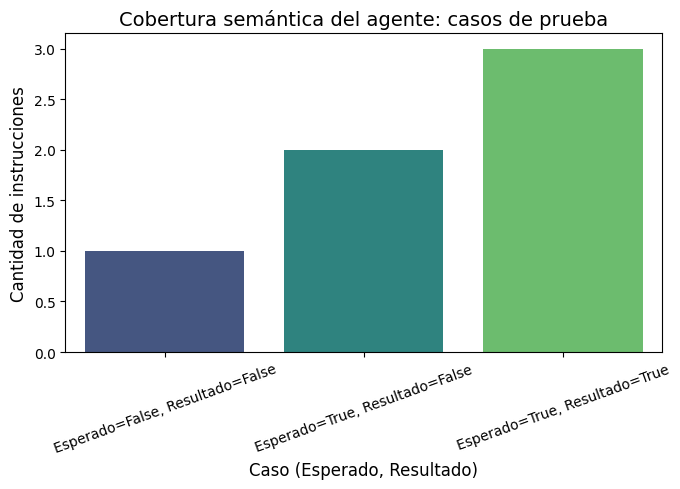

Tabla resumen de desempeño:


resultado,False,True
esperado,,
False,1,0
True,2,3


In [30]:
# Visualización de resultados de cobertura semántica
import matplotlib.pyplot as plt
import seaborn as sns

# Conteo de casos
conteo = df_eval.groupby(['esperado','resultado']).size().reset_index(name='cantidad')
conteo['caso'] = conteo.apply(lambda row: f"Esperado={row['esperado']}, Resultado={row['resultado']}", axis=1)

plt.figure(figsize=(7,5))
sns.barplot(data=conteo, x='caso', y='cantidad', palette='viridis')
plt.title('Cobertura semántica del agente: casos de prueba', fontsize=14)
plt.ylabel('Cantidad de instrucciones', fontsize=12)
plt.xlabel('Caso (Esperado, Resultado)', fontsize=12)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Tabla resumen de desempeño
print('Tabla resumen de desempeño:')
display(df_eval.groupby(['esperado','resultado']).size().unstack(fill_value=0))


## 6. Cobertura semántica y evaluación del agente
- Análisis de qué tipos de instrucciones el agente puede resolver correctamente y cuáles no.
- Ejemplos de instrucciones exitosas y fallidas.
- Métricas de cobertura: porcentaje de instrucciones resueltas, tipos de errores frecuentes.


In [31]:
# Ejemplo de integración de logging en el pipeline de análisis y generación de queries
import logging
import os

# Configuración de logs
os.makedirs('../logs', exist_ok=True)
logging.basicConfig(
    filename='../logs/pipeline.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s'
    )

logging.info('Inicio del análisis exploratorio y generación de queries')

# Ejemplo de log en cada paso relevante
logging.info('Carga y análisis de estructura del dataset completado')
logging.info('Cobertura y diversidad de instrucciones analizadas')
logging.info('Sinónimos normalizados y consulta traducida')
logging.info('Evaluación semántica del agente realizada')

print('Logs generados en ../logs/pipeline.log')

Logs generados en ../logs/pipeline.log
